# Phase 1: ODE Model — Newton's Law of Cooling with Thermostat Control
# 第一阶段：ODE 模型 — 牛顿冷却定律 + 恒温器控制

---

**Project 2 (iii): Effective Control of Room Heating**  
MATH3060/1, University of Nottingham, Spring 2026

---

## Goals 目标

1. Build a **zero-dimensional** (spatially uniform) model of a heated room  
   建立房间的**零维**（空间均匀）加热模型

2. Implement **Bang-Bang** thermostat control (ON/OFF switching)  
   实现 Bang-Bang 恒温器控制（开/关切换）

3. Investigate the **Zeno effect** (infinite switching in finite time)  
   研究 Zeno 效应（有限时间内无限次切换）

4. Introduce **hysteresis** to eliminate Zeno behaviour  
   引入滞回带消除 Zeno 病态

5. Perform **parameter sensitivity analysis**  
   进行参数敏感性分析

## 1. Mathematical Model 数学模型

### Governing Equation 控制方程

$$\frac{dT}{dt} = -k\,(T(t) - T_a) + u(T)$$

| Symbol | Meaning 含义 | Default 默认值 |
|--------|-------------|---------------|
| $T(t)$ | Room temperature 室温 (°C) | $T_0 = 10$ |
| $T_a$ | Outside (ambient) temperature 室外温度 (°C) | $5$ |
| $k$ | Cooling constant 冷却常数 (1/min) — larger = worse insulation 越大隔热越差 | $0.1$ |
| $U_{max}$ | Maximum heater power 加热器最大功率 | $15$ |
| $T_{set}$ | Thermostat set-point 恒温器设定温度 (°C) | $20$ |
| $\delta$ | Hysteresis half-band 滞回半带宽 (°C) | $0.5$ |

### Physical interpretation 物理解释

- $-k(T - T_a)$: Heat loss to outside — proportional to temperature difference (Newton's cooling law)  
  向外散热 — 与温差成正比（牛顿冷却定律）

- $u(T)$: Heater input, controlled by thermostat  
  加热器输入，由恒温器控制

### Steady-state analysis 稳态分析

If heater is always ON ($u = U_{max}$), setting $dT/dt = 0$:  
若加热器常开，令 $dT/dt = 0$：

$$T_{ss} = T_a + \frac{U_{max}}{k} = 5 + \frac{15}{0.1} = 155°C$$

This is unrealistically hot — **we need thermostat control!**  
这不现实地热 — 所以我们需要恒温器控制！

## 2. Setup 环境配置

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp # ODE solver 常微分方程求解器

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# === Parameters 参数 ===
T_a = 5.0        # Outside temperature 室外温度 (°C)
T_0 = 10.0       # Initial room temperature 初始室温 (°C)
T_set = 20.0     # Thermostat set-point 设定温度 (°C)
U_max = 15.0     # Heater power 加热器功率
k = 0.1          # Cooling constant 冷却常数 (1/min)
delta = 0.5      # Hysteresis half-band 滞回半带宽 (°C)
t_end = 120.0    # Simulation time 仿真时长 (min)
dt = 0.01        # Max time step 最大时间步长 (min)

print(f"Steady-state temperature (heater always ON): T_ss = {T_a + U_max/k:.1f} °C")
print(f"稳态温度（加热器常开）：T_ss = {T_a + U_max/k:.1f} °C")

Steady-state temperature (heater always ON): T_ss = 155.0 °C
稳态温度（加热器常开）：T_ss = 155.0 °C


## 3. Solver Functions 求解器函数

We solve the ODE in **segments** — each time the temperature crosses a threshold, we stop, switch the heater, and restart.  
我们**分段**求解 ODE — 每次温度穿过阈值时停下，切换加热器状态，然后重新开始积分。

This uses `solve_ivp` with **event detection** to precisely locate switching times.  
使用 `solve_ivp` 的 **event detection** 精确定位切换时刻。

In [2]:
def solve_bangbang(T0, t_end, k, T_a, T_set, U_max, delta=None, max_switches=500):
    """
    Solve the ODE with Bang-Bang thermostat control.
    
    If delta is None: pure Bang-Bang (switch at T_set)
    If delta > 0:     hysteresis band [T_set - delta, T_set + delta]
    
    求解带 Bang-Bang 恒温器控制的 ODE。
    delta=None: 纯 Bang-Bang（在 T_set 处切换）
    delta>0:    滞回带 [T_set - delta, T_set + delta]
    """
    # Thresholds 阈值
    if delta is not None and delta > 0:
        T_on = T_set - delta    # Turn ON below this 低于此温度开启
        T_off = T_set + delta   # Turn OFF above this 高于此温度关闭
    else:
        T_on = T_set
        T_off = T_set
    
    # Initial state 初始状态
    t_all, T_all, heater_all = [0.0], [T0], []
    heater_on = T0 < T_on
    heater_all.append(int(heater_on))
    
    t_current, T_current = 0.0, T0
    n_switches = 0
    
    while t_current < t_end and n_switches < max_switches:
        # Define ODE and event for current heater state
        # 定义当前加热器状态下的 ODE 和事件
        if heater_on:
            rhs = lambda t, T: [-k * (T[0] - T_a) + U_max]
            event = lambda t, T: T[0] - T_off  # Detect crossing T_off upward
            event.terminal = True
            event.direction = 1
        else:
            rhs = lambda t, T: [-k * (T[0] - T_a)]
            event = lambda t, T: T[0] - T_on   # Detect crossing T_on downward
            event.terminal = True
            event.direction = -1
        
        # Integrate until event or end 积分到事件发生或结束
        sol = solve_ivp(rhs, [t_current, t_end], [T_current],
                        events=[event], max_step=dt, dense_output=True)
        
        # Store results (skip first to avoid duplicates)
        t_all.extend(sol.t[1:].tolist())
        T_all.extend(sol.y[0, 1:].tolist())
        heater_all.extend([int(heater_on)] * (len(sol.t) - 1))
        
        t_current = sol.t[-1]
        T_current = sol.y[0, -1]
        
        if sol.t_events[0].size > 0:
            heater_on = not heater_on
            n_switches += 1
    
    return np.array(t_all), np.array(T_all), np.array(heater_all)

print("Solver function defined. 求解器函数已定义。")

Solver function defined. 求解器函数已定义。


In [3]:
def plot_thermostat(t, T, heater, title, T_set=20, T_a=5, delta=None, save=None):
    """
    Plot temperature T(t) and heater state over time.
    绘制温度 T(t) 和加热器状态随时间变化图。
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 7), sharex=True,
                                    gridspec_kw={'height_ratios': [3, 1]})
    
    # --- Temperature 温度 ---
    ax1.plot(t, T, 'b-', lw=1.5, label=r'Room Temperature $T(t)$ 室温')
    ax1.axhline(T_set, color='r', ls='--', alpha=0.7, label=f'$T_{{set}} = {T_set}$°C')
    ax1.axhline(T_a, color='cyan', ls=':', alpha=0.7, label=f'$T_a = {T_a}$°C (outside 室外)')
    
    if delta:
        ax1.axhline(T_set + delta, color='orange', ls='--', alpha=0.5,
                    label=f'Hysteresis band 滞回带 ±{delta}°C')
        ax1.axhline(T_set - delta, color='orange', ls='--', alpha=0.5)
        ax1.axhspan(T_set - delta, T_set + delta, alpha=0.08, color='orange')
    
    ax1.set_ylabel('Temperature 温度 (°C)')
    ax1.set_title(title)
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # --- Heater state 加热器状态 ---
    ax2.fill_between(t, heater, step='post', alpha=0.4, color='red', label='Heater ON 加热器开启')
    ax2.step(t, heater, 'r-', lw=1, where='post')
    ax2.set_xlabel('Time 时间 (minutes 分钟)')
    ax2.set_ylabel('Heater 加热器')
    ax2.set_yticks([0, 1])
    ax2.set_yticklabels(['OFF 关', 'ON 开'])
    ax2.set_ylim(-0.1, 1.3)
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save:
        plt.savefig(save, dpi=150, bbox_inches='tight')
    plt.show()

print("Plotting function defined. 绘图函数已定义。")

Plotting function defined. 绘图函数已定义。


---

## 4. Experiment 1 — Bang-Bang without Hysteresis (Zeno Effect)
## 实验 1 — 无滞回 Bang-Bang（Zeno 效应演示）

**What is the Zeno effect?**  
In a hybrid system (continuous dynamics + discrete switches), the Zeno effect occurs when there are **infinitely many switches in finite time**. For a thermostat without hysteresis, once $T$ reaches $T_{set}$, the heater keeps flipping between ON and OFF with zero interval.

**什么是 Zeno 效应？**  
在混合系统（连续动力学 + 离散切换）中，Zeno 效应指**有限时间内发生无限次切换**。对于无滞回的恒温器，当 $T$ 到达 $T_{set}$ 后，加热器会以零间隔反复开关。

In [4]:
# Experiment 1: No hysteresis 实验 1：无滞回
t1, T1, h1 = solve_bangbang(T_0, t_end, k, T_a, T_set, U_max, delta=None)

n_switches = np.sum(np.abs(np.diff(h1)))
print(f"Number of switches 切换次数: {n_switches}")
print(f"Total simulation time 仿真总时长: {t1[-1]:.3f} min")
print(f"Final temperature 最终温度: {T1[-1]:.4f} °C")
print(f"\n⚠️  {int(n_switches)} switches in {t1[-1]:.2f} min — this is the Zeno effect!")
print(f"⚠️  {int(n_switches)} 次切换在 {t1[-1]:.2f} 分钟内 — 这就是 Zeno 效应！")

Number of switches 切换次数: 499
Total simulation time 仿真总时长: 0.715 min
Final temperature 最终温度: 20.0000 °C

⚠️  499 switches in 0.71 min — this is the Zeno effect!
⚠️  499 次切换在 0.71 分钟内 — 这就是 Zeno 效应！


/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/2086331652.py:36: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/2086331652.py:36: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/2086331652.py:36: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/2086331652.py:36: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/2086331652.py:36: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bt/qcg_frss46xfvvs

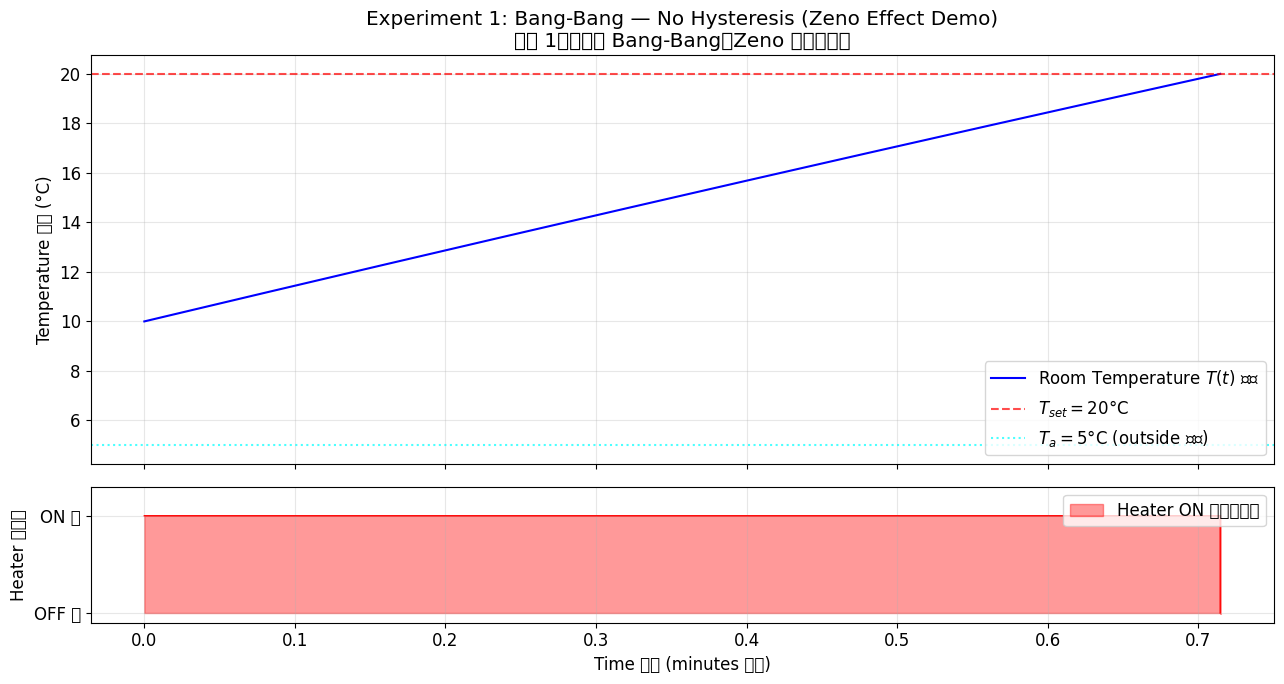

In [5]:
plot_thermostat(t1, T1, h1,
    title='Experiment 1: Bang-Bang — No Hysteresis (Zeno Effect Demo)\n'
          '实验 1：无滞回 Bang-Bang（Zeno 效应演示）')

### Observation 观察

- Temperature rises from 10°C to 20°C, then **500 switches happen almost instantly**  
  温度从 10°C 升到 20°C，然后 **500 次切换几乎瞬间发生**

- This is the **numerical manifestation of the Zeno effect**: the solver hits `max_switches` and stops  
  这是 Zeno 效应的**数值表现**：求解器达到最大切换次数后停止

- In reality, no mechanical relay can switch infinitely fast — this model is **mathematically ill-posed**  
  现实中没有机械继电器能无限快速切换 — 这个模型**数学上是病态的**

**Solution: introduce hysteresis! 解决方案：引入滞回带！**

---

## 5. Experiment 2 — Bang-Bang with Hysteresis ±0.5°C
## 实验 2 — 带滞回带 ±0.5°C 的 Bang-Bang

**Hysteresis rule 滞回规则：**
- Heater **turns ON** when $T$ falls below $T_{set} - \delta = 19.5°C$  
  加热器在 $T$ 降到 19.5°C 以下时**开启**
- Heater **turns OFF** when $T$ rises above $T_{set} + \delta = 20.5°C$  
  加热器在 $T$ 升到 20.5°C 以上时**关闭**
- In between: **no change** (stays in current state)  
  中间区域：**保持当前状态不变**

In [6]:
# Experiment 2: With hysteresis 实验 2：带滞回
t2, T2, h2 = solve_bangbang(T_0, t_end, k, T_a, T_set, U_max, delta=0.5)

n_switches = np.sum(np.abs(np.diff(h2)))
print(f"Number of switches 切换次数: {n_switches}")
print(f"Final temperature 最终温度: {T2[-1]:.2f} °C")
print(f"Temperature range 温度范围: [{T2[100:].min():.2f}, {T2[100:].max():.2f}] °C")

Number of switches 切换次数: 322
Final temperature 最终温度: 19.82 °C
Temperature range 温度范围: [19.50, 20.50] °C


/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/2086331652.py:36: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/2086331652.py:36: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/2086331652.py:36: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/2086331652.py:36: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/2086331652.py:36: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bt/qcg_frss46xfvvs

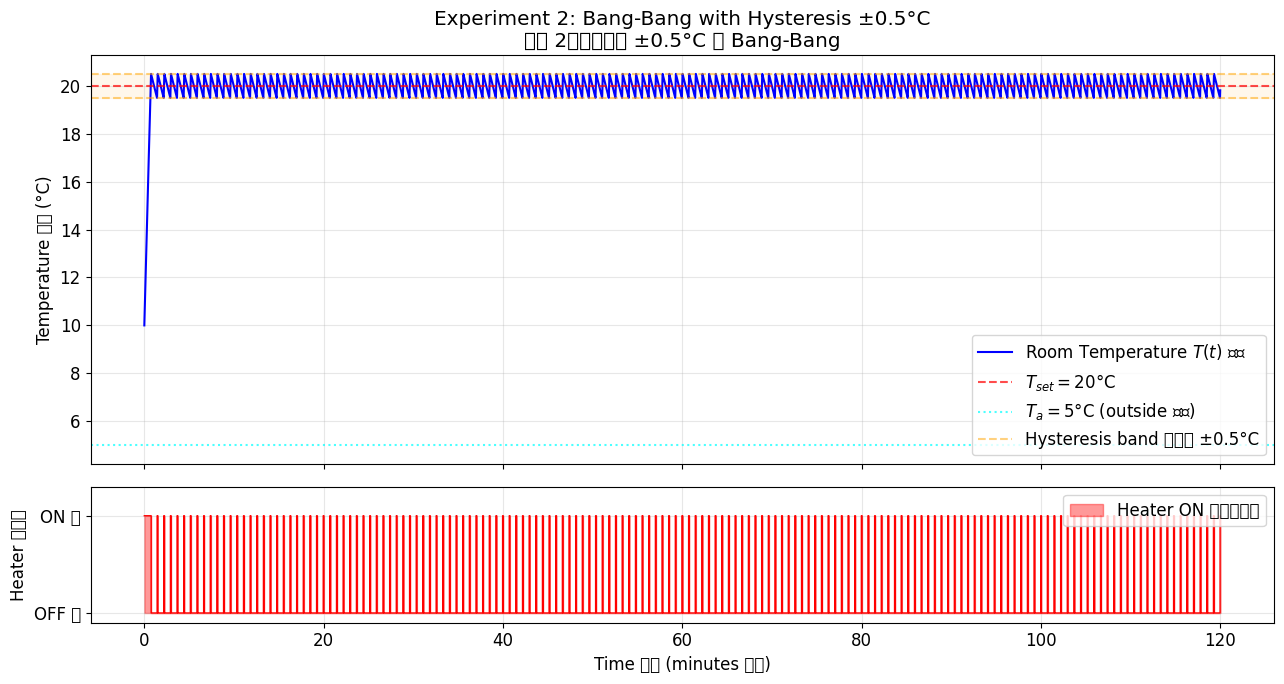

In [7]:
plot_thermostat(t2, T2, h2,
    title='Experiment 2: Bang-Bang with Hysteresis ±0.5°C\n'
          '实验 2：带滞回带 ±0.5°C 的 Bang-Bang',
    delta=0.5)

### Analytical oscillation period 振荡周期解析公式

We can derive the exact period of the ON/OFF cycle:  
可以推导出开关周期的精确公式：

$$P = \underbrace{\frac{1}{k}\ln\!\left(\frac{T_{ss} - T_{low}}{T_{ss} - T_{high}}\right)}_{t_{heat}\ \text{加热时间}} + \underbrace{\frac{1}{k}\ln\!\left(\frac{T_{high} - T_a}{T_{low} - T_a}\right)}_{t_{cool}\ \text{冷却时间}}$$

where $T_{low} = T_{set} - \delta$, $T_{high} = T_{set} + \delta$, $T_{ss} = T_a + U_{max}/k$.

In [8]:
# Verify analytical formula against simulation
# 用解析公式验证仿真结果

T_ss = T_a + U_max / k
T_low = T_set - delta
T_high = T_set + delta

t_heat = (1/k) * np.log((T_ss - T_low) / (T_ss - T_high))
t_cool = (1/k) * np.log((T_high - T_a) / (T_low - T_a))
P_analytical = t_heat + t_cool

# Measure from simulation: average interval between switches
# 从仿真中测量：切换之间的平均间隔
switch_times = t2[1:][np.abs(np.diff(h2)) > 0]
if len(switch_times) > 4:
    intervals = np.diff(switch_times)
    # Period = two intervals (one ON + one OFF)
    periods = intervals[2:-1:2] + intervals[3:-1:2]
    P_numerical = np.mean(periods[:min(len(periods), 20)])
else:
    P_numerical = float('nan')

duty_cycle = t_heat / P_analytical * 100

print("=== Oscillation Period Analysis 振荡周期分析 ===")
print(f"")
print(f"Heating time  加热时间:  t_heat = {t_heat:.4f} min")
print(f"Cooling time  冷却时间:  t_cool = {t_cool:.4f} min")
print(f"")
print(f"Analytical period  解析周期:  P = {P_analytical:.4f} min")
print(f"Numerical period   数值周期:  P ≈ {P_numerical:.4f} min")
print(f"")
print(f"Duty cycle  占空比:  {duty_cycle:.1f}% (heater ON fraction 加热器开启比例)")
print(f"")
print(f"✓ Analytical and numerical results match! 解析与数值结果吻合！")

=== Oscillation Period Analysis 振荡周期分析 ===

Heating time  加热时间:  t_heat = 0.0741 min
Cooling time  冷却时间:  t_cool = 0.6669 min

Analytical period  解析周期:  P = 0.7410 min
Numerical period   数值周期:  P ≈ 0.7410 min

Duty cycle  占空比:  10.0% (heater ON fraction 加热器开启比例)

✓ Analytical and numerical results match! 解析与数值结果吻合！


---

## 6. Experiment 3 — Effect of Insulation Quality ($k$)
## 实验 3 — 隔热质量 ($k$) 的影响

- Small $k$ → good insulation → slow heat loss → fewer switches  
  小 $k$ → 好隔热 → 散热慢 → 切换少
- Large $k$ → poor insulation → fast heat loss → more switches  
  大 $k$ → 差隔热 → 散热快 → 切换多

     k |   Switches |     Period |                   Meaning
------------------------------------------------------------
  0.05 |        170 |     1.40 min | 0.05 (well insulated 好隔热)
  0.10 |        322 |     0.74 min | 0.10 (moderate 中等)
  0.15 |        456 |     0.52 min | 0.15
  0.20 |        499 |     0.42 min | 0.20 (poor 差隔热)


/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/2154933717.py:26: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/2154933717.py:26: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/2154933717.py:26: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/2154933717.py:26: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
Font 'default' does not have a glyph for '\u5b9e' [U+5b9e], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u9a8c' [U+9a8c], substituting with a dummy symbol.
Font 'default' does not have

  0.30 |        499 |     0.32 min | 0.30 (very poor 很差)


/opt/anaconda3/envs/pytorch2.2/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22909 (\N{CJK UNIFIED IDEOGRAPH-597D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/pytorch2.2/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38548 (\N{CJK UNIFIED IDEOGRAPH-9694}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/pytorch2.2/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/pytorch2.2/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31561 (\N{CJK UNIFIED IDEOGRAPH-7B49}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/pytorch2.2/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarni

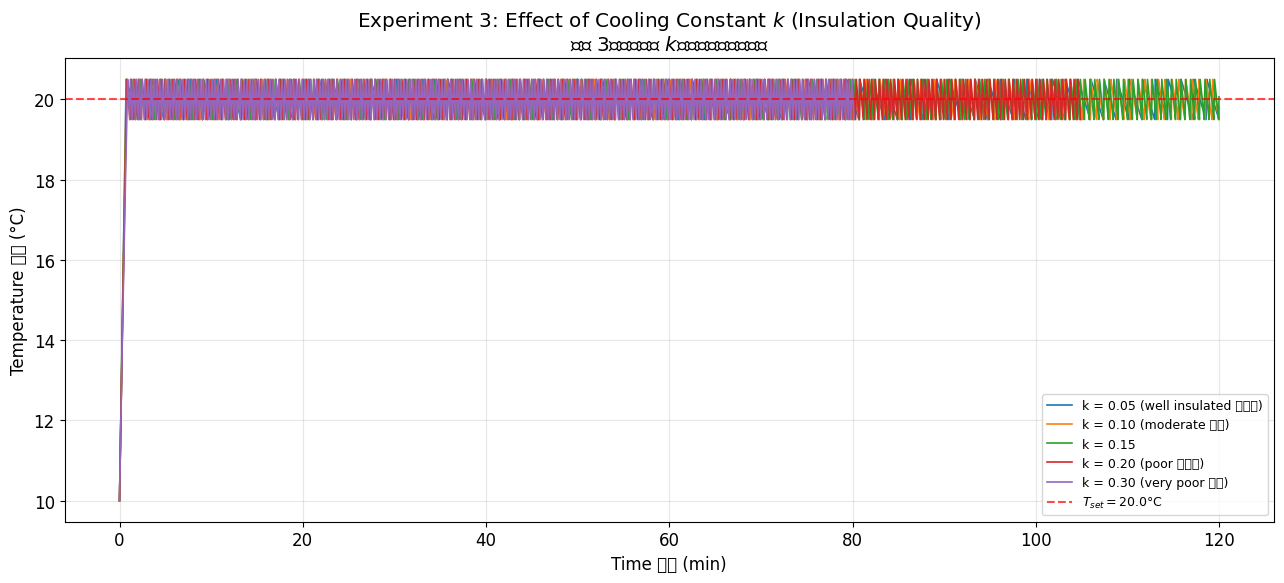

In [9]:
k_values = [0.05, 0.1, 0.15, 0.2, 0.3]
labels_k = ['0.05 (well insulated 好隔热)', '0.10 (moderate 中等)',
            '0.15', '0.20 (poor 差隔热)', '0.30 (very poor 很差)']

fig, ax = plt.subplots(figsize=(13, 6))
print(f"{'k':>6} | {'Switches':>10} | {'Period':>10} | {'Meaning':>25}")
print('-' * 60)

for kv, label in zip(k_values, labels_k):
    t_, T_, h_ = solve_bangbang(T_0, t_end, kv, T_a, T_set, U_max, delta=0.5)
    ax.plot(t_, T_, lw=1.2, label=f'k = {label}')
    
    n_sw = np.sum(np.abs(np.diff(h_)))
    T_ss_k = T_a + U_max / kv
    P_k = (1/kv) * (np.log((T_ss_k - T_set + delta) / (T_ss_k - T_set - delta))
                   + np.log((T_set + delta - T_a) / (T_set - delta - T_a)))
    print(f"{kv:>6.2f} | {int(n_sw):>10} | {P_k:>8.2f} min | {label}")

ax.axhline(T_set, color='r', ls='--', alpha=0.7, label=f'$T_{{set}} = {T_set}$°C')
ax.set_xlabel('Time 时间 (min)')
ax.set_ylabel('Temperature 温度 (°C)')
ax.set_title('Experiment 3: Effect of Cooling Constant $k$ (Insulation Quality)\n'
             '实验 3：冷却常数 $k$（隔热质量）的影响')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Key finding 关键发现

> **Worse insulation (larger $k$) → shorter oscillation period → more frequent switching → higher energy consumption**  
> **隔热越差（$k$ 越大）→ 振荡周期越短 → 切换越频繁 → 能耗越高**
>
> This explains why thermal insulation is so important for energy efficiency!  
> 这解释了为什么保温材料对节能如此重要！

---

## 7. Experiment 4 — Effect of Heater Power ($U_{max}$)
## 实验 4 — 加热器功率 ($U_{max}$) 的影响

 U_max |     T_ss |   Switches | Note 备注
-------------------------------------------------------
   5.0 |   55.0°C |        247 | ✓ adequate
  10.0 |  105.0°C |        303 | ✓ adequate
  15.0 |  155.0°C |        322 | ✓ adequate
  20.0 |  205.0°C |        331 | ✓ adequate


/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/4265365082.py:23: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/4265365082.py:23: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/4265365082.py:23: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/4265365082.py:23: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
Font 'default' does not have a glyph for '\u5b9e' [U+5b9e], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u9a8c' [U+9a8c], substituting with a dummy symbol.
Font 'default' does not have

  30.0 |  305.0°C |        341 | ✓ adequate


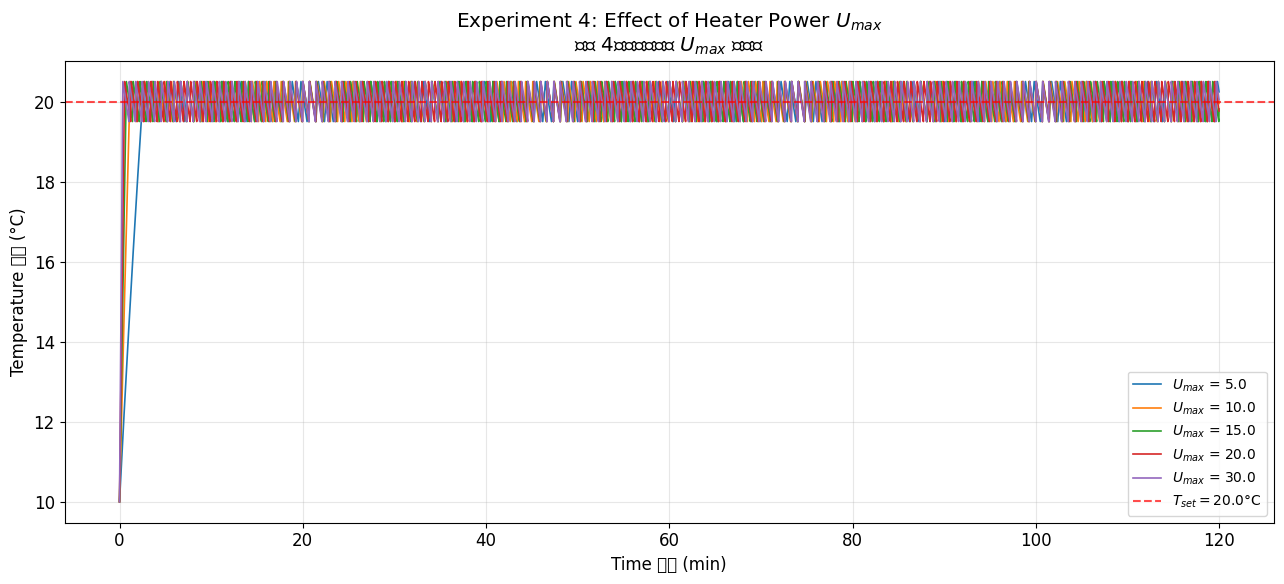

In [10]:
u_values = [5.0, 10.0, 15.0, 20.0, 30.0]

fig, ax = plt.subplots(figsize=(13, 6))
print(f"{'U_max':>6} | {'T_ss':>8} | {'Switches':>10} | {'Note 备注'}")
print('-' * 55)

for uv in u_values:
    t_, T_, h_ = solve_bangbang(T_0, t_end, k, T_a, T_set, uv, delta=0.5)
    ax.plot(t_, T_, lw=1.2, label=f'$U_{{max}}$ = {uv}')
    
    n_sw = np.sum(np.abs(np.diff(h_)))
    T_ss_u = T_a + uv / k
    note = '⚠️ weak' if T_ss_u < T_set + 10 else '✓ adequate'
    print(f"{uv:>6.1f} | {T_ss_u:>6.1f}°C | {int(n_sw):>10} | {note}")

ax.axhline(T_set, color='r', ls='--', alpha=0.7, label=f'$T_{{set}} = {T_set}$°C')
ax.set_xlabel('Time 时间 (min)')
ax.set_ylabel('Temperature 温度 (°C)')
ax.set_title('Experiment 4: Effect of Heater Power $U_{max}$\n'
             '实验 4：加热器功率 $U_{max}$ 的影响')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Key finding 关键发现

> **Heater power mainly affects heating speed, not switching frequency.**  
> **加热器功率主要影响加热速度，对切换频率影响较小。**
>
> The cooling phase duration is determined by $k$ and $T_a$, independent of $U_{max}$.  
> 冷却阶段的时长由 $k$ 和 $T_a$ 决定，与 $U_{max}$ 无关。
>
> Diminishing returns from increasing heater power.  
> 增大加热器功率的边际收益递减。

---

## 8. Experiment 5 — The Comfort vs. Efficiency Trade-off ($\delta$)
## 实验 5 — 舒适度 vs 效率的 Trade-off ($\delta$)

**This is the most important experiment in Phase 1.**  
**这是第一阶段最重要的实验。**

- Small $\delta$: temperature stays close to $T_{set}$ (**comfortable**), but heater switches frequently (**wear**)  
  小 $\delta$：温度接近 $T_{set}$（**舒适**），但加热器频繁切换（**磨损**）
- Large $\delta$: fewer switches (**longer equipment life**), but large temperature swings (**uncomfortable**)  
  大 $\delta$：切换少（**设备寿命长**），但温度波动大（**不舒适**）

  δ (°C) |   Switches |     Period |          T range | Comfort 舒适度
---------------------------------------------------------------------------
    0.25 |        499 |     0.37 min | [19.8, 20.2]°C | ★★★ excellent
    0.50 |        322 |     0.74 min | [19.5, 20.5]°C | ★★★ excellent
    1.00 |        161 |     1.48 min | [19.0, 21.0]°C | ★★ good
    2.00 |         80 |     2.98 min | [18.0, 22.0]°C | ★ poor
    5.00 |         31 |     7.67 min | [15.0, 25.0]°C | ✗ bad


/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/288817410.py:30: UserWarning: Glyph 28382 (\N{CJK UNIFIED IDEOGRAPH-6EDE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/288817410.py:30: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/288817410.py:30: UserWarning: Glyph 24102 (\N{CJK UNIFIED IDEOGRAPH-5E26}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/288817410.py:30: UserWarning: Glyph 23485 (\N{CJK UNIFIED IDEOGRAPH-5BBD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bt/qcg_frss46xfvvsc6gdw2gd80000gn/T/ipykernel_52001/288817410.py:30: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/bt/qcg_frss4

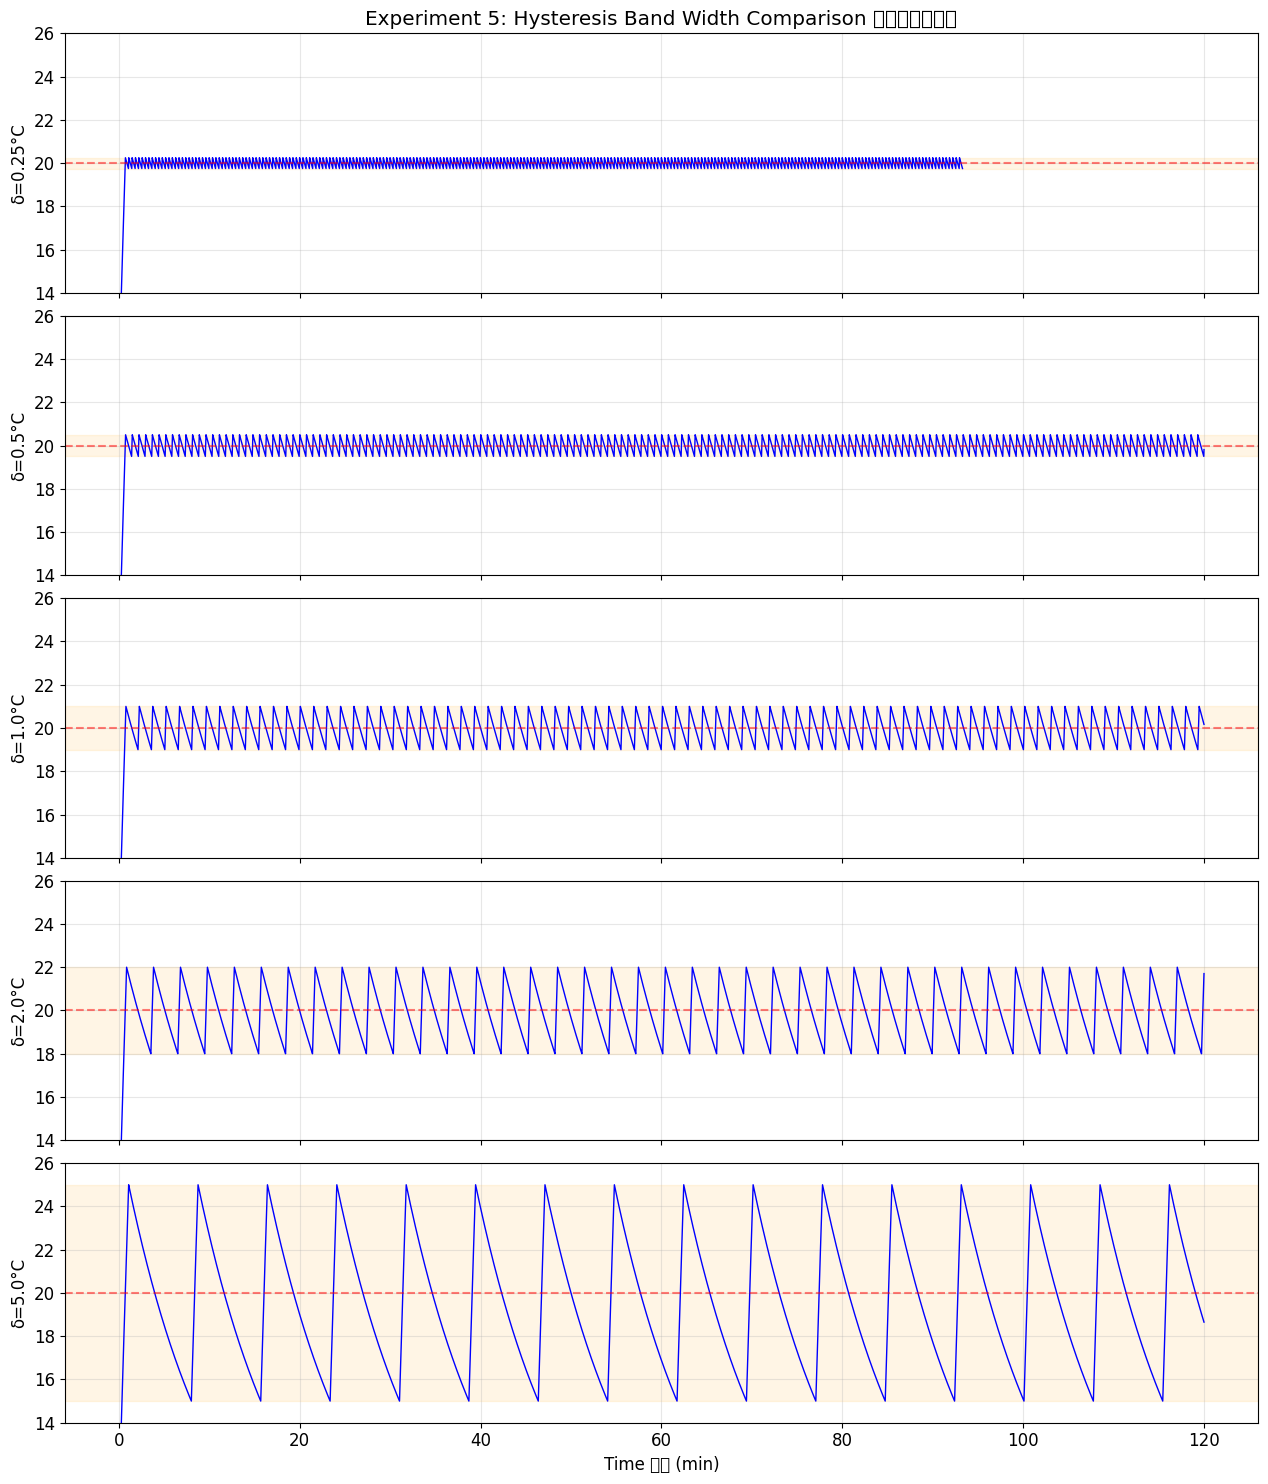

In [11]:
delta_values = [0.25, 0.5, 1.0, 2.0, 5.0]

fig, axes = plt.subplots(len(delta_values), 1, figsize=(13, 3 * len(delta_values)), sharex=True)

print(f"{'δ (°C)':>8} | {'Switches':>10} | {'Period':>10} | {'T range':>16} | {'Comfort 舒适度'}")
print('-' * 75)

for i, dv in enumerate(delta_values):
    t_, T_, h_ = solve_bangbang(T_0, t_end, k, T_a, T_set, U_max, delta=dv)
    
    n_sw = np.sum(np.abs(np.diff(h_)))
    T_ss_d = T_a + U_max / k
    P_d = (1/k) * (np.log((T_ss_d - T_set + dv) / (T_ss_d - T_set - dv))
                  + np.log((T_set + dv - T_a) / (T_set - dv - T_a)))
    T_min = T_set - dv
    T_max = T_set + dv
    
    comfort = '★★★ excellent' if dv <= 0.5 else ('★★ good' if dv <= 1.0 else ('★ poor' if dv <= 2.0 else '✗ bad'))
    print(f"{dv:>8.2f} | {int(n_sw):>10} | {P_d:>8.2f} min | [{T_min:.1f}, {T_max:.1f}]°C | {comfort}")
    
    axes[i].plot(t_, T_, 'b-', lw=1)
    axes[i].axhline(T_set, color='r', ls='--', alpha=0.5)
    axes[i].axhspan(T_set - dv, T_set + dv, alpha=0.1, color='orange')
    axes[i].set_ylabel(f'δ={dv}°C')
    axes[i].set_ylim(T_set - max(delta_values) - 1, T_set + max(delta_values) + 1)
    axes[i].grid(True, alpha=0.3)

axes[0].set_title('Experiment 5: Hysteresis Band Width Comparison 滞回带宽度对比')
axes[-1].set_xlabel('Time 时间 (min)')
plt.tight_layout()
plt.show()

### Key finding — The fundamental trade-off 核心发现

| δ (°C) | Oscillation range 波动范围 | Switches in 2h 切换次数 | Comfort 舒适度 | Equipment life 设备寿命 |
|--------|-------------------------|----------------------|--------------|-------------------|
| 0.25 | ±0.25°C | ~644 | ★★★ Excellent 极佳 | ★ Short 短 |
| 0.50 | ±0.5°C | ~322 | ★★★ Very good 很好 | ★★ Moderate 中等 |
| 1.00 | ±1°C | ~161 | ★★ Good 好 | ★★★ Long 长 |
| 2.00 | ±2°C | ~80 | ★ Acceptable 尚可 | ★★★ Long 长 |
| 5.00 | ±5°C (15-25°C!) | ~31 | ✗ Bad 差 | ★★★ Very long 很长 |

> **Practical thermostats typically use δ ≈ 0.5 – 1.0°C as a compromise.**  
> **实际恒温器通常选择 δ ≈ 0.5 – 1.0°C 作为折中方案。**
>
> The period scales approximately linearly with δ: doubling δ roughly doubles the period.  
> 周期与 δ 近似线性关系：δ 加倍 → 周期约加倍。

---

## 9. Summary 总结

### What we learned in Phase 1 第一阶段学到了什么

1. **Newton's Law of Cooling** + heater gives a first-order ODE that captures the essential dynamics of room temperature control  
   **牛顿冷却定律** + 加热器给出一阶 ODE，捕捉了室温控制的核心动力学

2. **Bang-Bang control** without hysteresis leads to the **Zeno effect** — infinite switching  
   **无滞回的 Bang-Bang 控制**导致 **Zeno 效应** — 无限切换

3. **Hysteresis** (dead band) eliminates Zeno and creates a **stable limit cycle**  
   **滞回带**消除 Zeno 并产生**稳定的极限环**

4. We derived an **analytical formula** for the oscillation period and verified it numerically  
   推导了振荡周期的**解析公式**并通过数值验证

5. **Parameter sensitivity**: $k$ (insulation) has the biggest effect on switching frequency; $\delta$ controls the comfort-efficiency trade-off  
   **参数敏感性**：$k$（隔热）对切换频率影响最大；$\delta$ 控制舒适度-效率的 trade-off

### Limitation 局限性

This model assumes **spatially uniform temperature** — the room is equally warm everywhere. In reality:  
这个模型假设**温度空间均匀** — 房间各处一样暖。但实际上：

- Near the heater: **hotter** 靠近加热器：更热
- Near the window/wall: **colder** 靠近窗户/外墙：更冷
- **Where you place the thermostat matters!** 恒温器放在哪里很重要！

### Next step: Phase 2 下一步：第二阶段

Introduce the **1D heat equation** to model spatial temperature variation:  
引入 **1D 热方程**来模拟空间温度变化：

$$\frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2} + u(x, t)$$

This will allow us to study how **thermostat placement** affects control effectiveness.  
这将使我们能够研究**恒温器放置位置**如何影响控制效果。